In [48]:
import GamificationRL
from collections import defaultdict
import gymnasium as gym
from GamificationRL.envs.gamification_elements import *
import random
from itertools import permutations
from adaptive_agent import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from hexad_answer_bot import *
plt.rcParams["figure.figsize"]=(10,7)

In [49]:
corr_g_e=list(corr_gamification_elements.values())
sample_g_e=list(sample_gamification_elements.values())
g_e=sample_g_e
hexad=hexad_load_dict(pl=0.5,ach=4,ph=3,dis=2,s=1,fs=5).load_dict
fatigue_penalty=0.1
fatigue_replenishment=0.01
nothing_reward=50
seed=101

In [50]:
env = gym.make('GamificationRL/GamificationPreferenceEnv-v0',
               hexad_load=hexad,
               gamification_elements=g_e,
               use_fatigue=True,
               individual_modifications=None,
               repetition_penalty=(500,1000),
               nothing_reward=nothing_reward,
               fatigue_reduction=fatigue_penalty,
               fatigue_replenish=fatigue_replenishment,
               seed=seed
               )
obs,_=env.reset()

In [51]:
learn_rate=0.001
discount_factor=0.95
epsilon=1
epsilon_min=0.1
training_iterations=int(1e6)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*4/5000)
#epsilon_decay=(epsilon-epsilon_min)/100

In [52]:

agent=RandomGreedyAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   choices=5)

train_error=agent.train(env=env,iterations=training_iterations,trunc_error=True)


  1%|          | 12/1000 [00:00<00:29, 34.03it/s]

100%|██████████| 1000/1000 [00:19<00:00, 50.71it/s]


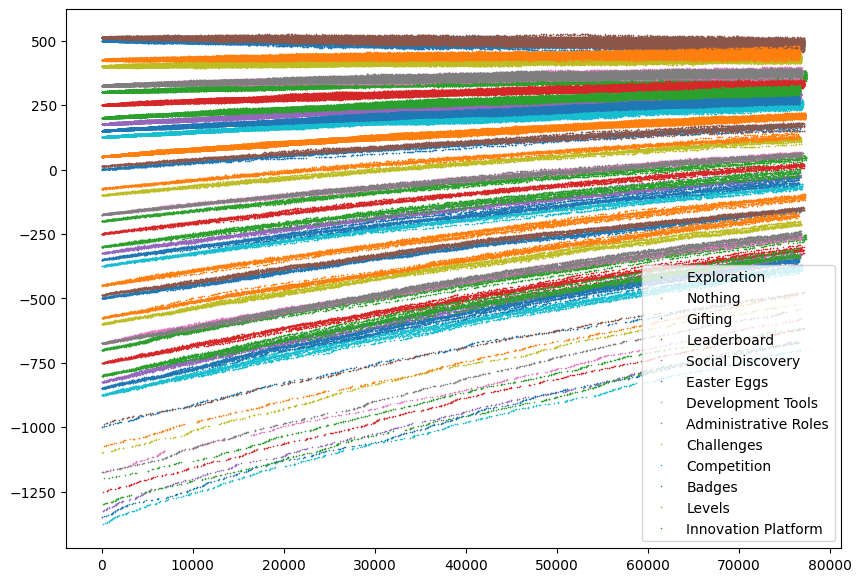

In [53]:
for action in train_error:
    plt.plot(train_error[action],marker='x',linestyle='',markersize=0.5,label=env.action_to_ge[action])
plt.legend()

In [54]:
uncertainty=.5
divisor=5.5
starting_threshold=.1
gain_modifier=0.01
amount=0.5


In [55]:
bot = ScoreChangeBot(
        hexad_types=copy.deepcopy(hexad),
        uncertainty= uncertainty,
        divisor=6,
        starting_change_threshold=starting_threshold,
        change_gain_modifier=gain_modifier,
        change_amount=amount,
        seed=seed,
    )

In [56]:
test_iterations=1000
retrain_iterations=1000
training_learn_rate=0.5
random_retrain=False


In [57]:
r=[]
b=[]
err=[]
actions=defaultdict(lambda:{'x':[],'y':[]})
#ans=['accept','decline']
#pick=np.random.randint(0,2,size=test_iterations)
obs,_=env.reset()
for i in tqdm(range(test_iterations)):
    #rand=pick[i]
    #answer=ans[rand]
    act=agent.get_action(obs,avoid_reps=True)
    h_type=env.ge[env.action_to_ge[act]].type
    answer,_=bot.get_answer(h_type)
    choice,reward,new_obs,info,error=agent\
        .step_and_update(env=env,
                         obs=obs,
                         answer=answer,
                         retrain_iterations=retrain_iterations,
                         learning_rate=training_learn_rate,
                         random_retrain=random_retrain,
                         act=act)
    b.append((choice,reward))
    r.append(reward)
    err.append(error)
    actions[choice]['x'].append(i)
    actions[choice]['y'].append(reward)
    obs=new_obs

  0%|          | 4/1000 [00:00<00:28, 35.40it/s]

100%|██████████| 1000/1000 [00:22<00:00, 44.45it/s]


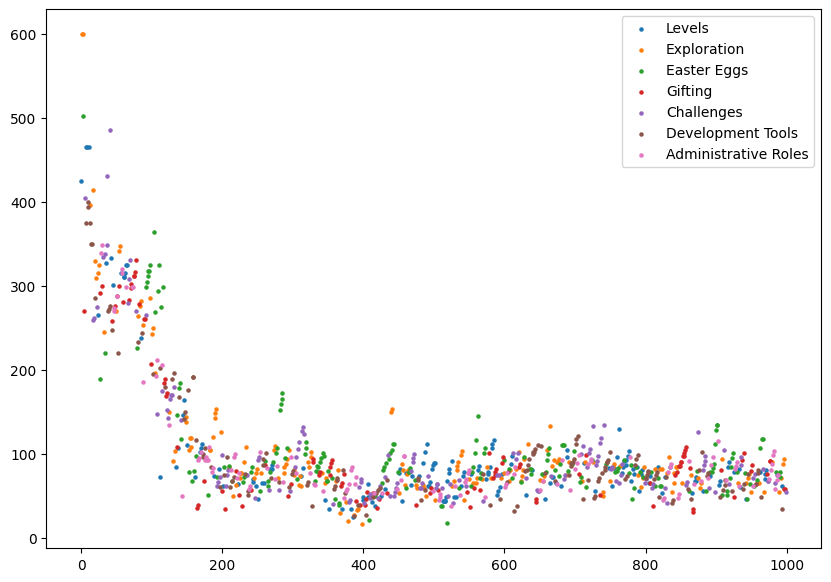

In [58]:
for i in actions:
    plt.scatter(actions[i]['x'],actions[i]['y'],label=env.action_to_ge[i],s=5)
ax=plt.gca()
ax.legend()


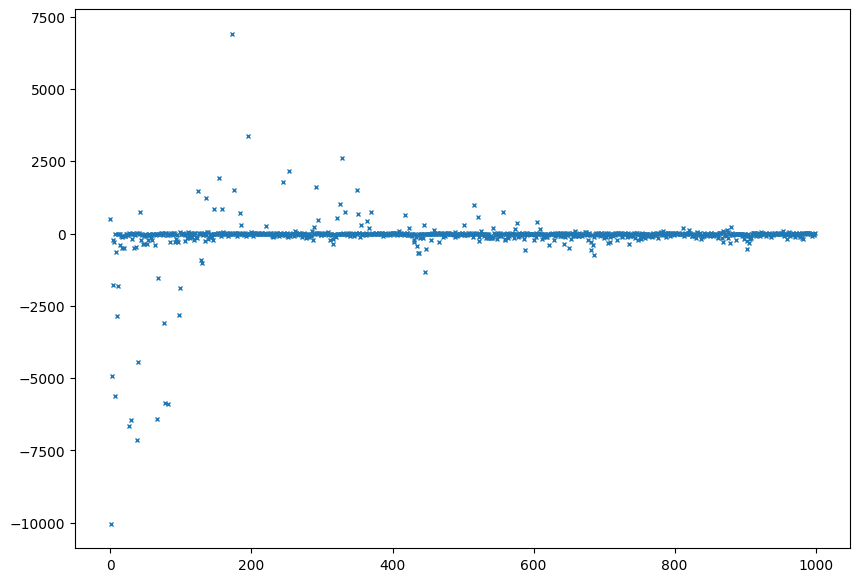

In [59]:
plt.plot(err,marker='x',linestyle='',markersize=3)

In [60]:
np.average((err)),\
np.percentile((err),75),\
np.median((err)),\
np.percentile((err),25),\
np.std(np.abs(err)),\
np.max((err)),\
np.min((err))

(-84.11189734318663,
 1.0804488579909162,
 -7.929302449606212,
 -56.593674481384426,
 737.3574195781115,
 6906.226544952006,
 -10036.123079463581)

In [61]:
np.average(np.abs(r)),\
np.std(np.abs(r)),\
np.max((r)),\
np.min((r))

(105.53407500000031, 81.0499414683279, 600.0000000000001, 17.000000000000288)

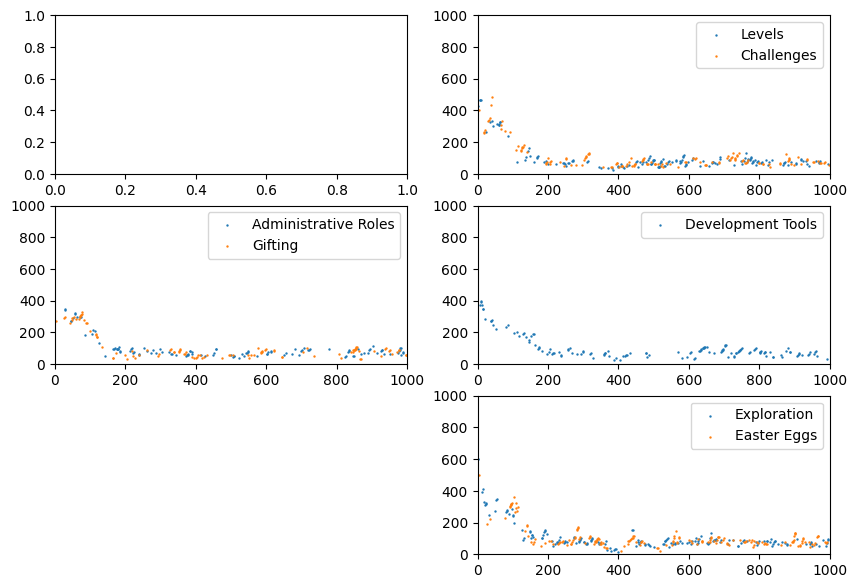

In [62]:
typ='pl'
j=1
plt.figure(1)
plt.subplot(3,2,j)
for i,_ in sorted(actions.items()):
    name=env.action_to_ge[i]
    hex_type=env.ge[name].type
    if hex_type!=None:
        plt.figure(1)
        type_index=hexad_types.index(env.ge[name].type)+1
    else:
        plt.figure(2)
    plt.subplot(3,2,type_index)
    plt.ylim(0,1000)
    plt.xlim(0,1000)
    plt.scatter(actions[i]['x'],actions[i]['y'],label=name,s=0.5)
    ax=plt.gca()
    ax.legend()

In [63]:
type_stats=defaultdict(lambda:0)
for i in actions:
    try:
        type_stats[sample_gamification_elements[env.action_to_ge[i]].type]+=len(actions[i]['x'])
    except KeyError:
        pass
for t in hexad:
    print(t,': ',hexad[t],', ',type_stats[t])


pl :  0.5 ,  0
ach :  4.0 ,  294
ph :  3.0 ,  221
dis :  2.0 ,  143
s :  1.0 ,  0
fs :  5.0 ,  342
